In [1]:
import numpy as np
import matplotlib.pyplot as plt
from codes.model import Model
from codes.solvers import solver
from codes import kwant_examples
from codes.kwant_helper import utils
from codes.tb.transforms import tb2kfunc, tb2kfunc
from codes.tb.tb import addTb
from tqdm import tqdm
import xarray as xr


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Create translationally-invariant `kwant.Builder`
graphene_builder, int_builder = kwant_examples.graphene_extended_hubbard()
tb_model = utils.builder2tb_model(graphene_builder)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [34]:
def compute_phase_diagram(Us, Vs, int_builder, tb_model): 
    gap = []
    ks = np.linspace(-np.pi, np.pi, 30)
    for U in tqdm(Us): 
        gap_U = []
        guess=None
        for V in Vs: 
            params = dict(U=U, V=V)
            int_model = utils.builder2tb_model(int_builder, params)
            if guess==None:
                guess = utils.generate_guess(frozenset(int_model), len(list(tb_model.values())[0]))
            model = Model(tb_model, int_model, filling=2)

            mf_sol = solver(model, guess, nK=9)
            hkfunc = tb2kfunc(addTb(tb_model, mf_sol))
            hkarray = np.array([hkfunc((kx, -kx)) for kx in ks])
            vals = np.linalg.eigvalsh(hkarray)
            gap_U.append(utils.calc_gap(vals, E_F=0))
            guess = addTb(tb_model, mf_sol)
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

In [36]:
Us = np.linspace(0, 3, 10, endpoint=True)
Vs = np.linspace(0, 1.5, 10, endpoint=True)
gap = compute_phase_diagram(Us, Vs, int_builder, tb_model)

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


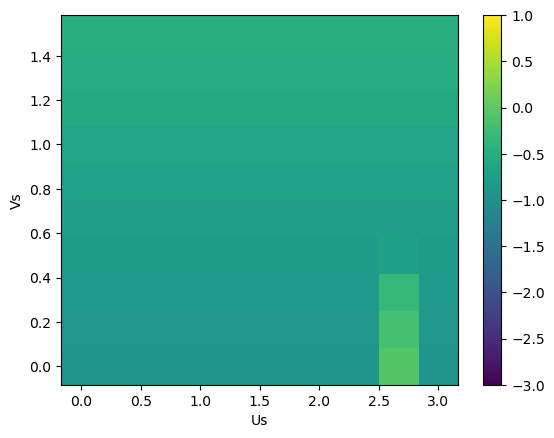

In [38]:
gap_da = xr.DataArray(data=gap, coords=dict(Us=Us, Vs=Vs))
np.log10(gap_da).plot(x="Us", y="Vs", vmin=-3, vmax=1) 

1.332443679186737

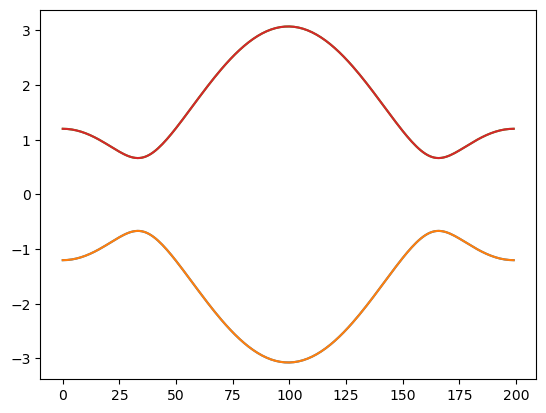

In [40]:
#Single shot calculation
params = dict(U=3, V=0)
filling = 2 

int_model = utils.builder2tb_model(int_builder, params)
model = Model(tb_model, int_model, filling)
mf_guess = utils.generate_guess(frozenset(int_model), len(list(tb_model.values())[0]))
mf_sol = solver(model, mf_guess, nK=20)

ks = np.linspace(-np.pi, np.pi, 200)
hkfunc = tb2kfunc(addTb(tb_model, mf_sol))
hkarray = np.array([hkfunc((kx, -kx)) for kx in ks])
vals = np.linalg.eigvalsh(hkarray)
plt.plot(vals)
utils.calc_gap(vals, E_F=0)